In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [2]:
df = pd.read_csv("uci-news-aggregator.csv")

In [3]:
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [4]:
df2 = df[["TITLE", "CATEGORY"]]

In [5]:
df2["CATEGORY"].value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [10]:
#I do aspire here to have balanced classes
num_cat = 45000
shuff = df2.reindex(np.random.permutation(df.index))

In [11]:
e = shuff[shuff["CATEGORY"] == "e"][:num_cat]
b = shuff[shuff["CATEGORY"] == "b"][:num_cat]
t = shuff[shuff["CATEGORY"] == "t"][:num_cat]
m = shuff[shuff["CATEGORY"] == "m"][:num_cat]

In [12]:
conc = pd.concat([e,b,t,m], ignore_index=True)
conc = conc.reindex(np.random.permutation(conc.index))
conc["LABEL"] = 0

In [14]:
#one hot encoded
conc.loc[conc["CATEGORY"] == "e", "LABEL"] = 0
conc.loc[conc["CATEGORY"] == "b", "LABEL"] = 1
conc.loc[conc["CATEGORY"] == "t", "LABEL"] = 2
conc.loc[conc["CATEGORY"] == "m", "LABEL"] = 3

In [16]:
print(conc["LABEL"][:10])

26153     0
107082    2
98320     2
3127      0
177516    3
115543    2
158232    3
46288     1
158877    3
143256    3
Name: LABEL, dtype: int64


In [17]:
labels = to_categorical(conc["LABEL"], num_classes = 4)
print(labels[:10])

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [20]:
conc.keys()

Index(['TITLE', 'CATEGORY', 'LABEL'], dtype='object')

In [23]:
conc.drop("CATEGORY", axis = 1)


,TITLE,LABEL
26153,"Selena Gomez's Parents HATE Justin Bieber, Are...",0
107082,OnePlus One vs Nexus 5: Which should I buy?,2
98320,Android Wear: Google's Smartwatch Plans Come I...,2
3127,HBO renews 'Game of Thrones' for two more seas...,0
177516,Drink Up: Court Rules Bloomberg's Large Soda B...,3
115543,Will on climate change report: 'Scientists are...,2
158232,Embrace Exercise and Enjoy Younger Skin Even a...,3
46288,UK markets scramble to price in 2014 rate rise,1
158877,Sugary drink bill fails to move foward,3
143256,Relay for Life committee meeting,3


,TITLE,CATEGORY,LABEL
26153,"Selena Gomez's Parents HATE Justin Bieber, Are...",e,0
107082,OnePlus One vs Nexus 5: Which should I buy?,t,2
98320,Android Wear: Google's Smartwatch Plans Come I...,t,2
3127,HBO renews 'Game of Thrones' for two more seas...,e,0
177516,Drink Up: Court Rules Bloomberg's Large Soda B...,m,3


In [24]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(conc['TITLE'].values)
sequences = tokenizer.texts_to_sequences(conc['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 51814 unique tokens.


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [29]:
epochs = 10
emb_dim = 128
batch_size = 256

In [31]:
print((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

((144000, 130), (144000, 4), (36000, 130), (36000, 4))


In [32]:
X.shape[1]

130

In [34]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 115200 samples, validate on 28800 samples
Epoch 1/10
115200/115200 [==============================] - 333s 3ms/step - loss: 0.8364 - acc: 0.6599 - val_loss: 0.3149 - val_acc: 0.8926
Epoch 2/10
115200/11

In [35]:
acc = model.evaluate(X_test, Y_test)
print("Loss:",acc[0])
print("Accuracy:",acc[1])

36000/36000 [==============================] - 60s 2ms/step
Loss: 0.22443234294818507
Accuracy: 0.9265277777777777


Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

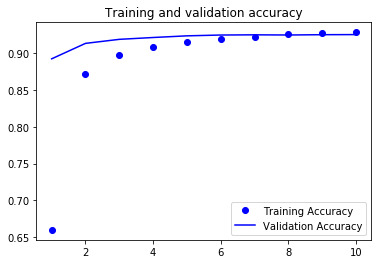

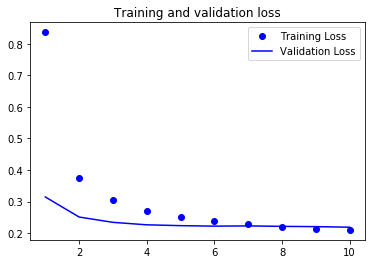

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[8.1045328e-05 1.7446009e-04 1.2415821e-04 9.9962032e-01]] health
